# SVM

In [1]:
# 데이터 구성 : Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화, 한글폰트
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')

# scaling
from sklearn.preprocessing import StandardScaler
# data split
from sklearn.model_selection import train_test_split
# SVM
from sklearn.svm import SVC
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

#### 데이터 구성하기

In [2]:
df_raw = pd.read_csv("D:/data/2/HMEQ.csv",encoding='euc-kr')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


#### 결측치 처리

In [3]:
# 데이터 구성하기 - 결측치 처리
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
# fillna 결측치 대체 함수
# JOB 변수의 결측치는 'Other'로 대체
df_raw['JOB'].fillna('Other', inplace= True)
df_raw.fillna(df_raw.mean(), inplace= True)

C:\Users\NOH TAEYUN\AppData\Local\Temp\ipykernel_6960\2444240324.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_raw.fillna(df_raw.mean(), inplace= True)


In [5]:
# 결측치 대체 확인
df_raw.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

#### 더미변수 생성

In [6]:
# 데이터 구성하기 - 더미변수 생성
# 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [7]:
# 데이터 구성하기 - 데이터 분할
# 설명변수, 목표변수 데이터 구분
df_raw_x = df_raw_dummy.drop('BAD', axis=1 ,inplace=False)
df_raw_y = df_raw_dummy['BAD']

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size=0.3, random_state=1234)

print('분할 전 설명변수 데이터:', df_raw_x.shape)
print('분할 후 설명변수 데이터:Train', df_train_x.shape, 'Test',df_test_x.shape)

분할 전 설명변수 데이터: (3748, 18)
분할 후 설명변수 데이터:Train (2623, 18) Test (1125, 18)


## SVC 모델 생성 - 기본 옵션으로 모델 생성

In [8]:
svm_uncustomized = SVC(random_state = 1234)
svm_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print('Accuracy on training set: {:.3f}'.format(svm_uncustomized.score(df_train_x, df_train_y)))
# test데이터 정확도
print('Accuracy on test set: {:.3f}'.format(svm_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.908
Accuracy on test set: 0.908


## SVC 모델 Parameter 변경 - C: 규제에 대한 강도 변경

In [9]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# c: 규제 (0.01, 0.1, 1 ,10)
para_c = [10 **c for c in range(-2,2)]
# para_c = [0.1 *c for c in range(1,10)] # C 변화 구간 변경

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

In [10]:
# C별 정확도 테이블
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.908,0.908
3,10.00,0.909,0.908


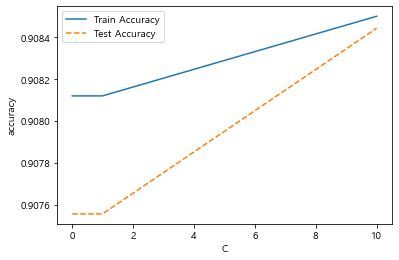

In [11]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_c, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('C')
plt.legend()

#### C가 1 이상이면 train 데이터 이용한 모델의 정확도는 1(과대적합) test 정확도는 변화 없음
#### C가 0.1 ~ 1.0 변화 시 정확도 확인 필요

In [12]:
C = 0.1

## SVC 모델 Parameter 변경 - Gamma : 훈련 샘플이 미치는 영향의 범위를 변경

In [13]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# gamma: 규제 (0.01, 0.1, 1 ,10)
para_gamma = [10 **gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 0.1, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [14]:
# Gamma별 정확도 테이블
df_accuracy_gamma.round(4)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.9081,0.9076
1,0.10,0.9081,0.9076
2,1.00,0.9081,0.9076
3,10.00,0.9081,0.9076


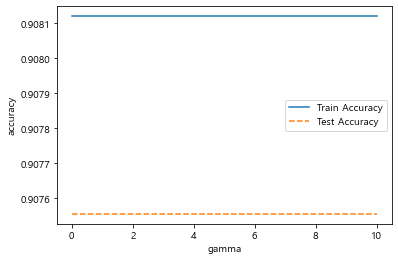

In [15]:
# 모델 정확도 그래프 확인
plt.plot(para_gamma, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_gamma, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('gamma')
plt.legend()

#### gamma 변화는 정확도에 영향을 미치지 않음
#### gamma 변화 구간을 변경하여 정확도 확인 가능

## scale 변환 - Standardscaler : 설명변수 값의 구간을 동일하게

In [16]:
# 변수명 저장
v_feature_name = df_train_x.columns
# StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [17]:
# 데이터 분할
df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size = 0.3, random_state= 1234)
print("train data X size: {}".format(df_scaled_train_x.shape))
print("test data X size: {}".format(df_scaled_test_x.shape))

train data X size: (2623, 18)
test data X size: (1125, 18)


## scale 조절 후 SVC 모델 재실행 - scale이 조정된 데이터로 새로운 모델 생성

In [18]:
svm_scaled = SVC(random_state= 1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
# train 데이터 셋 정확도
print('Accuracy on training set: {:.3f}'.format(svm_scaled.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print('Accuracy on test set: {:.3f}'.format(svm_scaled.score(df_scaled_test_x, df_test_y)))

Accuracy on training set: 0.944
Accuracy on test set: 0.935


#### sclae 조절 후 정확도가 올라간 것을 확인

## 새로운 SVC 모델 Parameter 변경 - C: 규제에 대한 강도 변경

In [19]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# c: 규제 (0.01, 0.1, 1 ,10)
para_c = [10 **c for c in range(-2,2)]
# para_c = [0.1 *c for c in range(1,10)] # C 변화 구간 변경

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

In [20]:
# C별 정확도 테이블
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.944,0.935
3,10.00,0.979,0.949


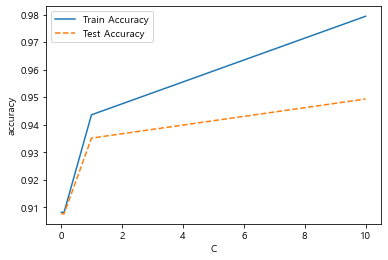

In [21]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_c, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('C')
plt.legend()

#### C가 1일 때 모델의 정확도가 많이 증가함
#### 필요시 C 변화 구간을 0.1 ~ 1.0 변경하여 정확도 확인 가능

In [22]:
# 임의로 지정
C = 1

## 새로운 SVC 모델 Parameter 변경 - Gamma: 훈련 샘플이 미치는 영향의 범위를 변경 결과

In [23]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# gamma: 규제 (0.01, 0.1, 1 ,10)
para_gamma = [10 **gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 1, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [24]:
# Gamma별 정확도 테이블
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.923,0.920
1,0.10,0.960,0.942
2,1.00,0.996,0.920
3,10.00,1.000,0.908


#### gamma가 1 이상이면 train 데이터의 모델은 과대적합
#### gamma 변화 구간을 변경하여 정확도 확인 가능

In [25]:
# 임의로 지정
gamma = 0.1

## 결론 도출 - 최종 모델 선택

In [28]:
svc_final = SVC(gamma = 0.1, C = 1, random_state= 1234)
svc_final.fit(df_scaled_train_x, df_train_y)
y_pred = svc_final.predict(df_scaled_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.4f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.4f}".format(svc_final.score(df_scaled_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
# 목표변수의 빈도 불귱형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.9596
Accuracy on test set: 0.9422
Confusion matrix: 
[[1021    0]
 [  65   39]]
              precision    recall  f1-score   support

           0      0.940     1.000     0.969      1021
           1      1.000     0.375     0.545       104

    accuracy                          0.942      1125
   macro avg      0.970     0.688     0.757      1125
weighted avg      0.946     0.942     0.930      1125



#### test 데이터 기준 정분류율은 94.2%
#### "1" 기준 f1 score는 54.5% (precision은 100%이나 recall이 매우 낮음)

## GridSearchCV를 이용한 최적 parameter 찾기

In [27]:
estimator = SVC(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"C":para_c,
             "gamma":para_gamma}
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring = "accuracy", n_jobs = -1)
grid_rf.fit(df_scaled_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
SVC(C=10, gamma=0.1, random_state=1234)

best parameter: 
{'C': 10, 'gamma': 0.1}

best score: 
0.96


#### GridSearch 결과 C=10, gamma=0.1일 때 모델의 정확도 가장 높음 (0.96)